In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Toggle numba if installed and you want more speed in the inner loop.
USE_NUMBA = False

KYBER_Q = 3329
QINV = -3327


def int16(x: int) -> int:
    x = x & 0xFFFF
    return x - 0x10000 if x & 0x8000 else x


def uint16(x: int) -> int:
    return x & 0xFFFF


def montgomery_reduce(a: int) -> int:
    t = int16(a)
    t = int16(t * QINV)
    res = (a - (int(t) * KYBER_Q)) >> 16
    return int16(res)


def fqmul(a: int, b: int) -> int:
    prod = int16(a) * int16(b)
    return uint16(montgomery_reduce(prod))


# optional numba compiled fqmul loop
if USE_NUMBA:
    try:
        from numba import njit, prange

        @njit
        def fqmul_numba(a: int, b: int) -> int:
            ax = a & 0xFFFF
            if ax & 0x8000:
                ax = ax - 0x10000
            bx = b & 0xFFFF
            if bx & 0x8000:
                bx = bx - 0x10000
            prod = ax * bx
            t = prod & 0xFFFFFFFF
            t = t & 0xFFFF
            t2 = ax * QINV
            res = (prod - t2 * KYBER_Q) >> 16
            res = res & 0xFFFF
            if res & 0x8000:
                res = res - 0x10000
            return res & 0xFFFF

        fqmul_impl = fqmul_numba
    except Exception:
        fqmul_impl = fqmul
        USE_NUMBA = False
else:
    fqmul_impl = fqmul





# Precompute HW lookup for bytes 0..255
HW_LOOKUP = np.array([bin(i).count("1") for i in range(256)], dtype=np.uint8)


def load_traces(path):
    traces = np.load(path)
    return traces.astype(np.float32)


def load_nonces(path):
    nonces = np.load(path)
    if nonces.dtype == np.uint8:
        if nonces.shape[1] % 2 != 0:
            raise ValueError("Nonce byte array must have even number of columns")
        nonces16 = nonces[:, ::2].astype(np.uint16) + (nonces[:, 1::2].astype(np.uint16) << 8)
        return nonces16
    return nonces.astype(np.uint16)


def compress(raw: np.ndarray, cf: int) -> np.ndarray:
    N, L = raw.shape
    CL = (L + cf - 1) // cf
    out = np.zeros((N, CL), dtype=np.float32)
    for i in range(CL):
        start, end = i * cf, min(L, (i + 1) * cf)
        out[:, i] = raw[:, start:end].mean(axis=1)
    return out




plot of poi

--- Analyzing Target 0 ---
Computing BSS score for Target 0 using 8000 traces...
Computation complete.


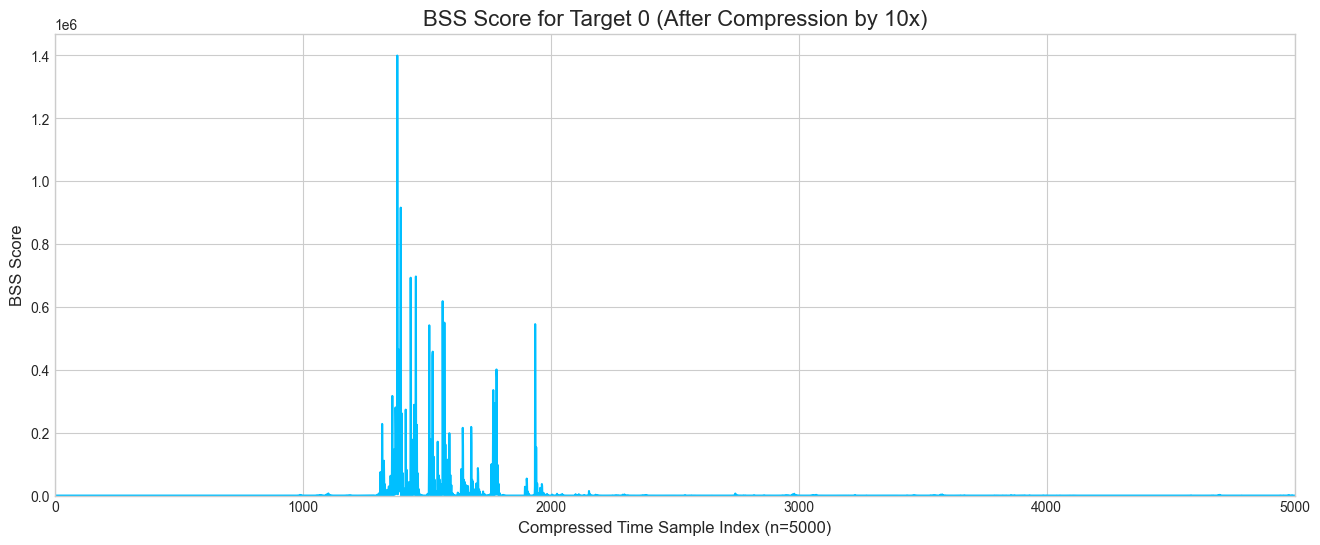


--- Analyzing Target 1 ---
Computing BSS score for Target 1 using 8000 traces...
Computation complete.


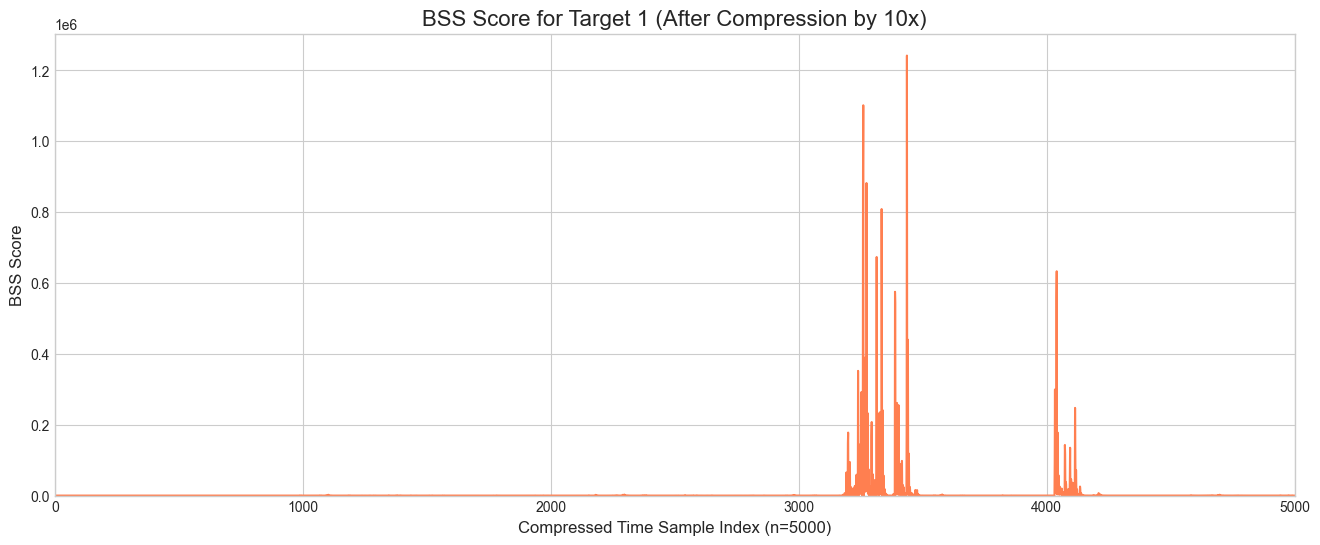

In [2]:


import matplotlib.pyplot as plt



def compute_between_class_poi_score(traces: np.ndarray, labels: np.ndarray, prof: int):
    """
    Compute between-class variance score for each time sample (ANOVA-like).
    This is also known as the Between-Sum-of-Squares (BSS) score.
    """
    Xp = traces[:prof]
    labs = labels[:prof]
    L = Xp.shape[1]
    
    mu_all = Xp.mean(axis=0)
    score = np.zeros(L, dtype=np.float64)
    
    classes = np.unique(labs)
    for c in classes:
        mask = (labs == c)
        n_c = np.sum(mask)
        if n_c == 0:
            continue
        mu_c = Xp[mask].mean(axis=0)
        diff_sq = (mu_c - mu_all) ** 2
        score += (n_c * diff_sq)
        
    return score

# --- Main script for plotting ---

# 1. Define File Paths and Parameters
traces_file = "tracesA0.npy"  # Assumes this file is in the same directory
nonces_file = "noncesA0.npy"  # Assumes this file is in the same directory
profFrac = 0.8                # Use 80% of traces for profiling
compressF = 10                # Compression factor (same as in the attack script)

# 2. Load and Prepare Data
try:
    raw_traces = load_traces(traces_file)
    nonces = load_nonces(nonces_file)
except FileNotFoundError:
    print(f"Error: Make sure '{traces_file}' and '{nonces_file}' are in the current directory.")
    raw_traces = np.random.rand(1000, 5000).astype(np.float32)
    nonces = np.random.randint(0, KYBER_Q, size=(1000, 6), dtype=np.uint16)

# Synchronize number of traces and compress
N = min(raw_traces.shape[0], nonces.shape[0])
raw_traces, nonces = raw_traces[:N], nonces[:N]
prof = max(1, int(profFrac * N))
compressed_traces = compress(raw_traces, compressF)
num_compressed_samples = compressed_traces.shape[1]

# Set a common style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# --- PLOT FOR TARGET 0 ---
print("--- Analyzing Target 0 ---")
idx_0 = 2  # Index for labeling Target 0
labels_0 = np.zeros(prof, dtype=np.int8)
for i in range(prof):
    val = int(nonces[i, idx_0])
    msb = (val >> 8) & 0xFF
    labels_0[i] = int(HW_LOOKUP[msb])

print(f"Computing BSS score for Target 0 using {prof} traces...")
bss_score_0 = compute_between_class_poi_score(compressed_traces, labels_0, prof)
print("Computation complete.")

fig0, ax0 = plt.subplots(figsize=(16, 6))
ax0.plot(range(num_compressed_samples), bss_score_0, color='deepskyblue', linewidth=1.5)
ax0.set_title(f"BSS Score for Target 0 (After Compression by {compressF}x)", fontsize=16)
ax0.set_xlabel(f"Compressed Time Sample Index (n={num_compressed_samples})", fontsize=12)
ax0.set_ylabel("BSS Score", fontsize=12)
ax0.set_xlim(0, num_compressed_samples)
ax0.set_ylim(bottom=0)
plt.show()


# --- PLOT FOR TARGET 1 ---
print("\n--- Analyzing Target 1 ---")
idx_1 = 5  # Index for labeling Target 1
labels_1 = np.zeros(prof, dtype=np.int8)
for i in range(prof):
    val = int(nonces[i, idx_1])
    msb = (val >> 8) & 0xFF
    labels_1[i] = int(HW_LOOKUP[msb])

print(f"Computing BSS score for Target 1 using {prof} traces...")
bss_score_1 = compute_between_class_poi_score(compressed_traces, labels_1, prof)
print("Computation complete.")

fig1, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot(range(num_compressed_samples), bss_score_1, color='coral', linewidth=1.5)
ax1.set_title(f"BSS Score for Target 1 (After Compression by {compressF}x)", fontsize=16)
ax1.set_xlabel(f"Compressed Time Sample Index (n={num_compressed_samples})", fontsize=12)
ax1.set_ylabel("BSS Score", fontsize=12)
ax1.set_xlim(0, num_compressed_samples)
ax1.set_ylim(bottom=0)
plt.show()

Random Forest Model

In [3]:
# --- Imports (add if not already present) ---
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier



def attack_rf_hw_multiclass(traces: np.ndarray, nonces: np.ndarray, prof: int, NUM_POI: int, which: int,
                            chunk=2048, rf_n_estimators=200, rf_n_jobs=-1, random_state=0):
    """
    RandomForest multi-class attack predicting HW classes 0..8.
    Returns best_guess (int), best_indices (list of int) tied for best log-likelihood.
    """
    N = traces.shape[0]
    att = N - prof
    if att <= 0:
        raise ValueError("Number of attack traces is zero or negative.")

    # Build HW labels on profiling set (0..8)
    idx = 2 if which == 0 else 5
    labels = np.zeros(prof, dtype=np.int8)
    for i in range(prof):
        val = int(nonces[i, idx])
        msb = (val >> 8) & 0xFF
        labels[i] = int(HW_LOOKUP[msb])  # 0..8

    # POI selection: between-class variance
    score = compute_between_class_poi_score(traces, labels, prof)
    pois = np.argsort(-score)[:NUM_POI]

    # Train classifier on profiling traces (features = traces at pois)
    X_train = traces[:prof, pois]
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)

    clf = RandomForestClassifier(n_estimators=rf_n_estimators, n_jobs=rf_n_jobs, random_state=random_state)
    clf.fit(X_train_s, labels)  # multi-class fit

    # Prepare attack features & probabilities
    X_attack = traces[prof:, pois]
    X_attack_s = scaler.transform(X_attack)  # shape (att, NUM_POI)
    probs = clf.predict_proba(X_attack_s)     # shape (att, n_classes) n_classes <= 9
    # Ensure columns correspond to class labels 0..8. sklearn returns columns in sorted label order.
    # Clip and log
    probs = np.clip(probs, 1e-15, 1.0)
    logprobs = np.log(probs)  # shape (att, n_classes)

    # attack nonce b values
    nonce_b = nonces[prof:, 1].astype(np.int64)

    guesses = np.arange(65536, dtype=np.int64)

    best_loglike = -np.inf
    best_guess = 0
    best_indices = []

    fqmul_local = fqmul_impl

    # chunked sweep
    for start in range(0, 65536, chunk):
        end = min(start + chunk, 65536)
        g_chunk = guesses[start:end]  # (cols,)
        cols = g_chunk.shape[0]

        # compute product matrix shape (att, cols)
        prod_chunk = np.empty((att, cols), dtype=np.uint16)
        for j in range(att):
            b = int(nonce_b[j])
            row = np.empty(cols, dtype=np.uint16)
            for k in range(cols):
                row[k] = fqmul_local(int(g_chunk[k]), b)
            prod_chunk[j, :] = row

        # msb and hw_class (0..8)
        msb_chunk = ((prod_chunk >> 8) & 0xFF).astype(np.uint8)  # shape (att, cols)
        hw_chunk = HW_LOOKUP[msb_chunk]  # shape (att, cols), values 0..8

        # clamp HW to classifier's known set (in case some classes weren't present during training)
        # sklearn's predict_proba columns correspond to clf.classes_
        classes_present = clf.classes_  # sorted array of present classes
        # Build index map from hw value to column index (or -1 if missing)
        class_to_col = {int(c): i for i, c in enumerate(classes_present)}
        # Create class indices array with -1 for unknown classes
        class_chunk = np.full(hw_chunk.shape, -1, dtype=np.int64)
        for hw_val in np.unique(hw_chunk):
            hw_mask = (hw_chunk == hw_val)
            if int(hw_val) in class_to_col:
                class_chunk[hw_mask] = class_to_col[int(hw_val)]
            else:
                # if a particular HW wasn't seen during training, assign a fallback class index:
                # choose the nearest seen HW by absolute difference (simple heuristic)
                seen = np.array(classes_present)
                nearest = seen[np.argmin(np.abs(seen - hw_val))]
                class_chunk[hw_mask] = class_to_col[int(nearest)]

        # compute log-likelihood per column: sum_j logprobs[j, class_chunk[j, col]]
        tot_loglike = np.zeros(cols, dtype=np.float64)
        for j in range(att):
            # gather column indices for row j
            cols_idx = class_chunk[j, :]
            # logprobs[j] shape (n_classes,)
            # safe indexing
            tot_loglike += logprobs[j, cols_idx]

        # find maxima in this chunk
        current_max = float(np.max(tot_loglike))
        cols_indices = np.where(tot_loglike == current_max)[0]

        if current_max > best_loglike + 1e-12:
            best_loglike = current_max
            best_guess = int(start + cols_indices[0])
            best_indices = [int(start + c) for c in cols_indices]
        elif np.isclose(current_max, best_loglike):
            best_indices.extend([int(start + c) for c in cols_indices])

    return int(best_guess), best_indices


# --- Runner example (single file) ---
if __name__ == "__main__":
    traces_file = "tracesA0.npy"
    nonces_file = "noncesA0.npy"
    compressF = 10
    NUM_POI = 500
    profFrac = 0.8
    CHUNK = 2048

    raw = load_traces(traces_file)
    nonces = load_nonces(nonces_file)
    N = min(raw.shape[0], nonces.shape[0])
    raw, nonces = raw[:N], nonces[:N]

    traces = compress(raw, compressF)
    prof = max(1, int(profFrac * N))

    print("Running RandomForest multi-class (HW 0..8) attack...")
    rec0, indices0 = attack_rf_hw_multiclass(traces, nonces, prof, NUM_POI, which=0,
                                             chunk=CHUNK, rf_n_estimators=200, rf_n_jobs=-1)
    rec1, indices1 = attack_rf_hw_multiclass(traces, nonces, prof, NUM_POI, which=1,
                                             chunk=CHUNK, rf_n_estimators=200, rf_n_jobs=-1)

    true0 = int(nonces[0, 0])
    true1 = int(nonces[0, 3])

    print(f"Recovered a0={rec0}, indices0={indices0}")
    print(f"Recovered a1={rec1}, indices1={indices1}")
    print(f"Ground truth a0={true0}, a1={true1}")
    print(f"Target0: {'Correct' if rec0 == true0 else 'Wrong'}")
    print(f"Target1: {'Correct' if rec1 == true1 else 'Wrong'}")
    print(f"count raw indices: {len(indices0)} {len(indices1)}")
    indices0_mod_set = {int(x) % KYBER_Q for x in indices0}
    indices1_mod_set = {int(x) % KYBER_Q for x in indices1}
    indices0_mod_sorted = sorted(indices0_mod_set)
    indices1_mod_sorted = sorted(indices1_mod_set)

    print(f"indices0 unique mod {KYBER_Q} = {indices0_mod_sorted}")
    print(f"indices1 unique mod {KYBER_Q} = {indices1_mod_sorted}")

Running RandomForest multi-class (HW 0..8) attack...
Recovered a0=558, indices0=[558]
Recovered a1=17, indices1=[17]
Ground truth a0=558, a1=17
Target0: Correct
Target1: Correct
count raw indices: 1 1
indices0 unique mod 3329 = [558]
indices1 unique mod 3329 = [17]


logistic regression(multinomial),svc

In [6]:
# === Imports for logistic / linear SVM multiclass attacks ===
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV



def _generic_attack_from_clf(clf, scaler, traces, nonces, prof, pois, chunk, hw_threshold_profile):
    """
    Shared chunked likelihood sweep: clf must implement predict_proba on scaled features.
    Returns best_guess, best_indices.
    """
    N = traces.shape[0]
    att = N - prof
    if att <= 0:
        raise ValueError("Number of attack traces is zero or negative.")

    # Prepare attack features & probabilities
    X_attack = traces[prof:, pois]
    X_attack_s = scaler.transform(X_attack)  # shape (att, NUM_POI)
    probs = clf.predict_proba(X_attack_s)     # shape (att, n_classes)
    probs = np.clip(probs, 1e-15, 1.0)
    logprobs = np.log(probs)  # (att, n_classes)

    nonce_b = nonces[prof:, 1].astype(np.int64)
    guesses = np.arange(65536, dtype=np.int64)

    best_loglike = -np.inf
    best_guess = 0
    best_indices = []

    fqmul_local = fqmul_impl

    # map class label -> column index in probs
    classes_present = clf.classes_
    class_to_col = {int(c): i for i, c in enumerate(classes_present)}

    # chunked sweep
    for start in range(0, 65536, chunk):
        end = min(start + chunk, 65536)
        g_chunk = guesses[start:end]  # (cols,)
        cols = g_chunk.shape[0]

        # compute product matrix (att, cols)
        prod_chunk = np.empty((att, cols), dtype=np.uint16)
        for j in range(att):
            b = int(nonce_b[j])
            row = np.empty(cols, dtype=np.uint16)
            for k in range(cols):
                row[k] = fqmul_local(int(g_chunk[k]), b)
            prod_chunk[j, :] = row

        # msb and hw_class (0..8)
        msb_chunk = ((prod_chunk >> 8) & 0xFF).astype(np.uint8)  # (att, cols)
        hw_chunk = HW_LOOKUP[msb_chunk]  # values 0..8

        # map hw_chunk values to columns indices (fallback to nearest seen class if missing)
        class_chunk = np.full(hw_chunk.shape, -1, dtype=np.int64)
        seen = np.array(classes_present)
        for hw_val in np.unique(hw_chunk):
            mask = (hw_chunk == hw_val)
            if int(hw_val) in class_to_col:
                class_chunk[mask] = class_to_col[int(hw_val)]
            else:
                # fallback: nearest seen HW
                nearest = seen[np.argmin(np.abs(seen - hw_val))]
                class_chunk[mask] = class_to_col[int(nearest)]

        # accumulate log-likelihoods
        tot_loglike = np.zeros(cols, dtype=np.float64)
        for j in range(att):
            cols_idx = class_chunk[j, :]
            tot_loglike += logprobs[j, cols_idx]

        current_max = float(np.max(tot_loglike))
        cols_indices = np.where(tot_loglike == current_max)[0]

        if current_max > best_loglike + 1e-12:
            best_loglike = current_max
            best_guess = int(start + cols_indices[0])
            best_indices = [int(start + c) for c in cols_indices]
        elif np.isclose(current_max, best_loglike):
            best_indices.extend([int(start + c) for c in cols_indices])

    return int(best_guess), best_indices

# ---------------- Logistic Regression (multinomial) ---------------- #
def attack_logistic_hw_multiclass(traces: np.ndarray, nonces: np.ndarray, prof: int, NUM_POI: int, which: int,
                                  chunk=2048, hw_threshold_profile=2, C=1.0, max_iter=2000, random_state=0):
    """
    Multinomial Logistic Regression predicting HW classes 0..8.
    """
    N = traces.shape[0]
    att = N - prof
    if att <= 0:
        raise ValueError("Number of attack traces is zero or negative.")

    # Build HW labels on profiling set (0..8)
    idx = 2 if which == 0 else 5
    labels = np.zeros(prof, dtype=np.int8)
    for i in range(prof):
        val = int(nonces[i, idx])
        msb = (val >> 8) & 0xFF
        labels[i] = int(HW_LOOKUP[msb])  # 0..8

    # POI selection: between-class variance
    score = compute_between_class_poi_score(traces, labels, prof)
    pois = np.argsort(-score)[:NUM_POI]

    # Train logistic regression (multinomial)
    X_train = traces[:prof, pois]
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)

    clf = LogisticRegression( solver='lbfgs',
                             C=C, max_iter=max_iter, random_state=random_state)
    clf.fit(X_train_s, labels)  # multi-class fit

    # run generic sweep using clf
    return _generic_attack_from_clf(clf, scaler, traces, nonces, prof, pois, chunk, hw_threshold_profile)

# ---------------- Linear SVC + Calibration (multiclass) ---------------- #
def attack_linear_svc_hw_multiclass(traces: np.ndarray, nonces: np.ndarray, prof: int, NUM_POI: int, which: int,
                                    chunk=2048, hw_threshold_profile=2, C=1.0, cv_calib=5, max_iter=5000, random_state=0):
    """
    Linear SVM (LinearSVC) with probability calibration for HW multiclass (0..8).
    """
    N = traces.shape[0]
    att = N - prof
    if att <= 0:
        raise ValueError("Number of attack traces is zero or negative.")

    # Build HW labels on profiling set (0..8)
    idx = 2 if which == 0 else 5
    labels = np.zeros(prof, dtype=np.int8)
    for i in range(prof):
        val = int(nonces[i, idx])
        msb = (val >> 8) & 0xFF
        labels[i] = int(HW_LOOKUP[msb])  # 0..8

    # POI selection: between-class variance
    score = compute_between_class_poi_score(traces, labels, prof)
    pois = np.argsort(-score)[:NUM_POI]

    # Train LinearSVC + CalibratedClassifierCV
    X_train = traces[:prof, pois]
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)

    svc = LinearSVC(C=C, max_iter=max_iter, dual=False, random_state=random_state)
    clf = CalibratedClassifierCV(svc, cv=cv_calib, method='sigmoid')
    clf.fit(X_train_s, labels)

    return _generic_attack_from_clf(clf, scaler, traces, nonces, prof, pois, chunk, hw_threshold_profile)

# ---------------- Runner (single file) ---------------- #
if __name__ == "__main__":
    traces_file = "tracesA0.npy"
    nonces_file = "noncesA0.npy"

    compressF = 10
    NUM_POI = 500
    profFrac = 0.8
    CHUNK = 2048
    HW_THRESHOLD_PROFILE = 2

    raw = load_traces(traces_file)
    nonces = load_nonces(nonces_file)
    N = min(raw.shape[0], nonces.shape[0])
    raw, nonces = raw[:N], nonces[:N]

    traces = compress(raw, compressF)
    prof = max(1, int(profFrac * N))
#logistic regression
    print("Running multinomial LogisticRegression (HW 0..8) attack...")
    rec0_log, idx0_log = attack_logistic_hw_multiclass(traces, nonces, prof, NUM_POI, which=0,
                                                       chunk=CHUNK, hw_threshold_profile=HW_THRESHOLD_PROFILE,
                                                       C=1.0, max_iter=2000)
    rec1_log, idx1_log = attack_logistic_hw_multiclass(traces, nonces, prof, NUM_POI, which=1,
                                                       chunk=CHUNK, hw_threshold_profile=HW_THRESHOLD_PROFILE,
                                                       C=1.0, max_iter=2000)
    print(f"Logistic Recovered a0={rec0_log}, indices0={idx0_log}")
    print(f"Logistic Recovered a1={rec1_log}, indices1={idx1_log}")

    
    print(f"count raw indices: {len(idx0_log)} {len(idx1_log)}")
    indices0_mod_set = {int(x) % KYBER_Q for x in idx0_log}
    indices1_mod_set = {int(x) % KYBER_Q for x in idx1_log}
    indices0_mod_sorted = sorted(indices0_mod_set)
    indices1_mod_sorted = sorted(indices1_mod_set)

    print(f"indices0 unique mod {KYBER_Q} = {indices0_mod_sorted}")
    print(f"indices1 unique mod {KYBER_Q} = {indices1_mod_sorted}")
 #svc
    print("\nRunning LinearSVC (calibrated) attack...")
    rec0_svc, idx0_svc = attack_linear_svc_hw_multiclass(traces, nonces, prof, NUM_POI, which=0,
                                                         chunk=CHUNK, hw_threshold_profile=HW_THRESHOLD_PROFILE,
                                                         C=1.0, cv_calib=5, max_iter=5000)
    rec1_svc, idx1_svc = attack_linear_svc_hw_multiclass(traces, nonces, prof, NUM_POI, which=1,
                                                         chunk=CHUNK, hw_threshold_profile=HW_THRESHOLD_PROFILE,
                                                         C=1.0, cv_calib=5, max_iter=5000)
    print(f"LinearSVC Recovered a0={rec0_svc}, indices0={idx0_svc}")
    print(f"LinearSVC Recovered a1={rec1_svc}, indices1={idx1_svc}")

    true0 = int(nonces[0, 0])
    true1 = int(nonces[0, 3])
    print(f"\nGround truth a0={true0}, a1={true1}")
    print(f"count raw indices: {len(idx0_svc)} {len(idx1_svc)}")
    indices0_mod_set = {int(x) % KYBER_Q for x in idx0_svc}
    indices1_mod_set = {int(x) % KYBER_Q for x in idx1_svc}
    indices0_mod_sorted = sorted(indices0_mod_set)
    indices1_mod_sorted = sorted(indices1_mod_set)

    print(f"indices0 unique mod {KYBER_Q} = {indices0_mod_sorted}")
    print(f"indices1 unique mod {KYBER_Q} = {indices1_mod_sorted}")
    print(f"Logistic Target0: {'Correct' if rec0_log == true0 else 'Wrong'}")
    print(f"Logistic Target1: {'Correct' if rec1_log == true1 else 'Wrong'}")
    print(f"LinearSVC Target0: {'Correct' if rec0_svc == true0 else 'Wrong'}")
    print(f"LinearSVC Target1: {'Correct' if rec1_svc == true1 else 'Wrong'}")


    
   


Running multinomial LogisticRegression (HW 0..8) attack...
Logistic Recovered a0=558, indices0=[558]
Logistic Recovered a1=17, indices1=[17]
count raw indices: 1 1
indices0 unique mod 3329 = [558]
indices1 unique mod 3329 = [17]

Running LinearSVC (calibrated) attack...
LinearSVC Recovered a0=558, indices0=[558]
LinearSVC Recovered a1=17, indices1=[17]

Ground truth a0=558, a1=17
count raw indices: 1 1
indices0 unique mod 3329 = [558]
indices1 unique mod 3329 = [17]
Logistic Target0: Correct
Logistic Target1: Correct
LinearSVC Target0: Correct
LinearSVC Target1: Correct


single layer perceptron

In [5]:

import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


def attack_dl_hw_multiclass(traces: np.ndarray, nonces: np.ndarray, prof: int, NUM_POI: int, which: int,
                            chunk=2048, batch_size=64, epochs=30, lr=1e-3, val_split=0.1, random_state=0):
    """
    Perceptron (single dense softmax) multi-class attack predicting HW classes 0..8.
    Returns best_guess (int), best_indices (list of int) tied for best log-likelihood.
    """
    N = traces.shape[0]
    att = N - prof
    if att <= 0:
        raise ValueError("Number of attack traces is zero or negative.")

    # Build HW labels on profiling set (0..8)
    idx = 2 if which == 0 else 5
    labels_raw = np.zeros(prof, dtype=np.int8)
    for i in range(prof):
        val = int(nonces[i, idx])
        msb = (val >> 8) & 0xFF
        labels_raw[i] = int(HW_LOOKUP[msb])  # 0..8

    # POI selection: between-class variance
    score = compute_between_class_poi_score(traces, labels_raw, prof)
    pois = np.argsort(-score)[:NUM_POI]

    # Prepare training data
    X_train = traces[:prof, pois]
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)

    # Map classes_present to contiguous indices so model output columns correspond to classes_present
    classes_present = np.unique(labels_raw)
    classes_present_sorted = np.sort(classes_present)
    class_to_index = {int(c): i for i, c in enumerate(classes_present_sorted)}
    y_train_idx = np.array([class_to_index[int(x)] for x in labels_raw], dtype=np.int32)
    n_classes = len(classes_present_sorted)

    # One-hot labels
    y_train_cat = to_categorical(y_train_idx, num_classes=n_classes)

    # Build simple perceptron model
    np.random.seed(random_state)
    import tensorflow as tf
    tf.random.set_seed(random_state)

    model = Sequential([
        InputLayer(shape=(NUM_POI,)),
        Dense(n_classes, activation='softmax')  # single-layer perceptron
    ])
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping (small patience)
    es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=0)

    # Fit model
    model.fit(X_train_s, y_train_cat,
              batch_size=batch_size, epochs=epochs, validation_split=val_split,
              callbacks=[es], verbose=1)

    # Prepare attack features & probabilities
    X_attack = traces[prof:, pois]
    X_attack_s = scaler.transform(X_attack)  # shape (att, NUM_POI)
    probs = model.predict(X_attack_s, batch_size=256)  # shape (att, n_classes)
    probs = np.clip(probs, 1e-15, 1.0)
    logprobs = np.log(probs)  # shape (att, n_classes)

    # attack nonce b values
    nonce_b = nonces[prof:, 1].astype(np.int64)

    guesses = np.arange(65536, dtype=np.int64)

    best_loglike = -np.inf
    best_guess = 0
    best_indices = []

    fqmul_local = fqmul_impl  # assumed available in global scope

    # chunked sweep (same logic as RF code)
    for start in range(0, 65536, chunk):
        end = min(start + chunk, 65536)
        g_chunk = guesses[start:end]  # (cols,)
        cols = g_chunk.shape[0]

        # compute product matrix shape (att, cols)
        prod_chunk = np.empty((att, cols), dtype=np.uint16)
        for j in range(att):
            b = int(nonce_b[j])
            row = np.empty(cols, dtype=np.uint16)
            for k in range(cols):
                row[k] = fqmul_local(int(g_chunk[k]), b)
            prod_chunk[j, :] = row

        # msb and hw_class (0..8)
        msb_chunk = ((prod_chunk >> 8) & 0xFF).astype(np.uint8)  # shape (att, cols)
        hw_chunk = HW_LOOKUP[msb_chunk]  # shape (att, cols), values 0..8

        # Map hw values to model columns (class indices). If unseen, pick nearest seen class.
        # classes_present_sorted gives the class values corresponding to model columns 0..n_classes-1
        seen = classes_present_sorted
        # Build mapping from seen value -> index
        seen_to_idx = {int(v): i for i, v in enumerate(seen)}
        # Create class indices array with -1 for unknown classes
        class_chunk = np.full(hw_chunk.shape, -1, dtype=np.int64)
        unique_hw_vals = np.unique(hw_chunk)
        for hw_val in unique_hw_vals:
            mask = (hw_chunk == hw_val)
            if int(hw_val) in seen_to_idx:
                class_chunk[mask] = seen_to_idx[int(hw_val)]
            else:
                # fallback: nearest seen class by absolute difference
                nearest = seen[np.argmin(np.abs(seen - hw_val))]
                class_chunk[mask] = seen_to_idx[int(nearest)]

        # Compute total log-likelihood per column
        tot_loglike = np.zeros(cols, dtype=np.float64)
        # vectorized accumulation over rows:
        for j in range(att):
            cols_idx = class_chunk[j, :]  # indices into logprobs[j]
            tot_loglike += logprobs[j, cols_idx]

        current_max = float(np.max(tot_loglike))
        cols_indices = np.where(tot_loglike == current_max)[0]

        if current_max > best_loglike + 1e-12:
            best_loglike = current_max
            best_guess = int(start + cols_indices[0])
            best_indices = [int(start + c) for c in cols_indices]
        elif np.isclose(current_max, best_loglike):
            best_indices.extend([int(start + c) for c in cols_indices])

    return int(best_guess), best_indices


# --- Example runner (single file) ---
if __name__ == "__main__":
    traces_file = "tracesA0.npy"
    nonces_file = "noncesA0.npy"
    compressF = 10
    NUM_POI = 500
    profFrac = 0.8
    CHUNK = 2048

    raw = load_traces(traces_file)
    nonces = load_nonces(nonces_file)
    N = min(raw.shape[0], nonces.shape[0])
    raw, nonces = raw[:N], nonces[:N]

    traces = compress(raw, compressF)
    prof = max(1, int(profFrac * N))

    print("Running Perceptron (DL) multi-class (HW 0..8) attack...")
    rec0, indices0 = attack_dl_hw_multiclass(traces, nonces, prof, NUM_POI, which=0,
                                             chunk=CHUNK, batch_size=64, epochs=30, lr=1e-3)
    rec1, indices1 = attack_dl_hw_multiclass(traces, nonces, prof, NUM_POI, which=1,
                                             chunk=CHUNK, batch_size=64, epochs=30, lr=1e-3)

    true0 = int(nonces[0, 0])
    true1 = int(nonces[0, 3])

    print(f"Recovered a0={rec0}, indices0={indices0}")
    print(f"Recovered a1={rec1}, indices1={indices1}")
    print(f"Ground truth a0={true0}, a1={true1}")
    print(f"Target0: {'Correct' if rec0 == true0 else 'Wrong'}")
    print(f"Target1: {'Correct' if rec1 == true1 else 'Wrong'}")
    print(f"count raw indices: {len(indices0)} {len(indices1)}")
    indices0_mod_set = {int(x) % KYBER_Q for x in indices0}
    indices1_mod_set = {int(x) % KYBER_Q for x in indices1}
    indices0_mod_sorted = sorted(indices0_mod_set)
    indices1_mod_sorted = sorted(indices1_mod_set)   
    print(f"indices0 unique mod {KYBER_Q} = {indices0_mod_sorted}")
    print(f"indices1 unique mod {KYBER_Q} = {indices1_mod_sorted}")                                                                                               

Running Perceptron (DL) multi-class (HW 0..8) attack...
Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4913 - loss: 1.0176 - val_accuracy: 0.5675 - val_loss: 0.8716
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5900 - loss: 0.8380 - val_accuracy: 0.6150 - val_loss: 0.7983
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6300 - loss: 0.7735 - val_accuracy: 0.6425 - val_loss: 0.7549
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6586 - loss: 0.7301 - val_accuracy: 0.6712 - val_loss: 0.7250
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6797 - loss: 0.6970 - val_accuracy: 0.6862 - val_loss: 0.7006
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6982 - loss: 0.6704 - val_accuracy: 0.6925 - val_loss: 0.6809
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7128 - loss: 0.6481 - val_accuracy: 0.7113 - val_loss: 0.6633
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s